In [ ]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle

# Keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, Bidirectional
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
print(gensim.__version__)

4.3.1


In [ ]:
!pip install bnlp_toolkit
!pip install bnltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# DATASET
DATASET_COLUMNS = ["comment_text", "toxic", "threat", "obscene", "religion"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 6
BATCH_SIZE = 16


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/last_dataset.csv')


In [ ]:
stop_words = open('/content/drive/MyDrive/Dataset/stopwords-bn.txt','r',encoding='utf-8').read().split()

In [ ]:
# Cleaning Data [Remove unncessary symbols]
def cleaning_documents(articles):
      '''
      This function will clean the news articles by removing punctuation marks and stopwords.

      Args:
      articles: a news text(str)

      returns:
      news: clean text (str)
      '''
      # news = articles.replace('\n',' ')
      news = re.sub('[^\u0980-\u09FF]',' ',str(articles)) #removing unnecessary punctuation
      # stopwords removal
      stp = open('/content/drive/MyDrive/Dataset/stopwords-bn.txt','r',encoding='utf-8').read().split()
      result = news.split()
      news = [word.strip() for word in result if word not in stp ]
      news =" ".join(news)
      return news

In [ ]:
# cleaning_documents(df)

In [ ]:
df

,comment_text,toxic,threat,obscene,religious
0,"অয় ভাই,লজ্জাবতী লতা_____ হেতেরে গে দিয়া চুম্মা।",1,0,1,0
1,"অসভ্য,",1,0,0,0
2,অসুবিধা নাই। নিজেরা দুর্নিতি করে সহযোগিদের ফা...,1,0,1,0
3,"অারিপ্পার পুটকিতে বাল গজুক অার নাই গজুক, অাজ ...",1,0,1,0
4,আইভি সাথে নির্বাচন করতে হলে খালেদা জিয়া লাগবে...,1,0,1,0
...,...,...,...,...,...
20279,হ্লার পুত তুই।,1,0,0,0
20280,"হ্লার পুত দিলি দিনটাই খারাপ করে,,,",1,0,0,0
20281,হ্লার পুতের বাপে মন অয় কম দামি কন্ডম ইউজ করতো।...,1,0,1,0
20282,হ্লার মাইয়া নিজেরে শো অফ করানোর লাইগে নাস্তিক...,0,0,0,1


In [ ]:
#df = shuffle(df)
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 16227
TEST size: 4057


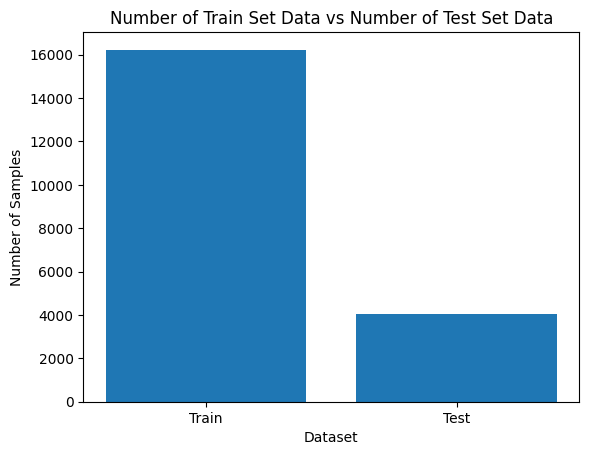

In [ ]:
import matplotlib.pyplot as plt
from tensorflow import keras

# Get the number of samples in the training and test sets
num_train_samples = df_train.shape[0]
num_test_samples = df_test.shape[0]

# Plot the number of samples
plt.bar(['Train', 'Test'], [num_train_samples, num_test_samples])
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')
plt.title('Number of Train Set Data vs Number of Test Set Data')
plt.show()

In [ ]:
df_test = df_test.loc[((df_test['toxic'] == 1) | (df_test['threat'] == 1) | (df_test['obscene'] ==1) | (df_test['religious'] == 1))]
LABEL_COLUMNS = df_test.columns.tolist()[1:]
df_test[LABEL_COLUMNS].sum()

toxic        1960
threat        414
obscene      1783
religious    1781
dtype: int64

In [ ]:
df_train

,comment_text,toxic,threat,obscene,religious
8191,তওবা করতে হবে,0,0,0,1
5532,কালো ধন,0,0,1,0
11628,"না আসলে তর প্রব্লেম টা কি,,, হালার হোগাচোদা,,,...",1,0,1,0
5631,কিনকির পোলা পারলে পেজ এ ফটো কমেন্ট অপশন টা চাল...,1,1,0,0
1853,আমার সাউয়া,1,0,1,0
...,...,...,...,...,...
11284,দোস্ত বুঝছস কিছু কিছু আবাল আছে যারা দশ মাস দশ ...,1,0,1,0
11964,নাস্তিক কে নাস্তিক এইতো বলবে,0,0,0,1
5390,কাছের মানুষটা দূরে ফেলে বারোভাতারি করতে খুউব ম...,1,0,1,0
860,"আগে নিজে লুচ্চামি ছাড়, ভালো হ।মানুষের জন্য ভাল...",1,0,1,0


In [ ]:
documents = [_text.split() for _text in df_train.comment_text] 

In [ ]:
documents

[['তওবা', 'করতে', 'হবে'],
 ['কালো', 'ধন'],
 ['না',
  'আসলে',
  'তর',
  'প্রব্লেম',
  'টা',
  'কি,,,',
  'হালার',
  'হোগাচোদা,,,',
  'মনডায়',
  'চাইতাসে',
  'মোবাইল',
  'বাইব্রেশন',
  'কইরা',
  'তর',
  'পুটকি',
  'দিয়ে',
  'ডুকাই',
  'দেই',
  'হ্লা',
  'নাটকির',
  'বাচ্চা'],
 ['কিনকির',
  'পোলা',
  'পারলে',
  'পেজ',
  'এ',
  'ফটো',
  'কমেন্ট',
  'অপশন',
  'টা',
  'চালু',
  'কর।।তোরে',
  'গালি',
  'যা',
  'দিমু',
  'তা',
  'লিখতে',
  'গেলে',
  'হাত',
  'ব্যাথা',
  'করব।।ফটোতে',
  'একবারে',
  'সব',
  'দিয়া',
  'দিমু।।'],
 ['আমার', 'সাউয়া'],
 ['তোমার', 'চোদা..', 'সারা'],
 ['সাফা',
  'কবির',
  'কানকীসাফা',
  'মাগী',
  'বুস্কি➕➕সাফা',
  'মাগী',
  'চুতমারানি',
  '➕সাফা',
  'মাগী',
  'তোমাকে',
  'চু****দে',
  'ভার্চুয়াল',
  'থেকে',
  'দূরে',
  'পাঠানোর',
  'ব্যাবস্থা',
  'করা',
  'উচিৎ',
  'সাফা',
  'মাগী',
  'টুমি',
  'নাস্তিক',
  'সাফা',
  'মাগী',
  'তরে',
  'রাতের',
  'অন্ধকারে',
  'উপ্তানো',
  'দরকার',
  '✌সাফা',
  'ইজ',
  'রিয়েলি',
  'কান****কী'],
 ['যার',
  'পুরো',
  'ফ্যামিলি',
  'নাস্ত

In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=300, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [ ]:
# w2v_model.build_vocab(documents)

In [ ]:
print(gensim.__version__)


4.3.1


In [ ]:
words = w2v_model.build_vocab(documents)
# vocab_size = len(words)
# print("Vocab size:", vocab_size)

In [ ]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(5680958, 8864128)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.comment_text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 37212


In [ ]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.comment_text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.comment_text), maxlen=SEQUENCE_LENGTH)

In [ ]:
df_train

,comment_text,toxic,threat,obscene,religious
8191,তওবা করতে হবে,0,0,0,1
5532,কালো ধন,0,0,1,0
11628,"না আসলে তর প্রব্লেম টা কি,,, হালার হোগাচোদা,,,...",1,0,1,0
5631,কিনকির পোলা পারলে পেজ এ ফটো কমেন্ট অপশন টা চাল...,1,1,0,0
1853,আমার সাউয়া,1,0,1,0
...,...,...,...,...,...
11284,দোস্ত বুঝছস কিছু কিছু আবাল আছে যারা দশ মাস দশ ...,1,0,1,0
11964,নাস্তিক কে নাস্তিক এইতো বলবে,0,0,0,1
5390,কাছের মানুষটা দূরে ফেলে বারোভাতারি করতে খুউব ম...,1,0,1,0
860,"আগে নিজে লুচ্চামি ছাড়, ভালো হ।মানুষের জন্য ভাল...",1,0,1,0


In [ ]:
labels = ['toxic','threat','obscene','religious']
labels

['toxic', 'threat', 'obscene', 'religious']

In [ ]:
y_train = df_train[['toxic', 'threat', 'obscene', 'religious']].values

In [ ]:
y_test = df_test[['toxic', 'threat', 'obscene', 'religious']].values

In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (16227, 300)
y_train (16227, 4)

x_test (4057, 300)
y_test (4057, 4)


In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(37212, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import regularizers
from tensorflow.keras.optimizers import Adam

In [ ]:
embedding_dim = 300
max_length = 300
trunc_type='post'
oov_tok = "<OOV>"

In [ ]:
with tf.device('/gpu:0'):
    model= Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Conv1D(200, kernel_size=3, activation = "leaky_relu"))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(50, activation='leaky_relu'))
    model.add(Dense(256, activation='leaky_relu'))
    model.add(Flatten())
    #l2 regularizer
    model.add(Dense(100,kernel_regularizer=regularizers.l2(1e-12),activation="leaky_relu"))
    model.add(Dense(4, activation='sigmoid'))
    #sgd= SGD(lr=0.0001,decay=1e-6,momentum=0.9,nesterov=True)
    adam=Adam(learning_rate=0.005,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
    model.summary()
    model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          11163600  
                                                                 
 conv1d (Conv1D)             (None, 298, 200)          180200    
                                                                 
 bidirectional (Bidirectiona  (None, 298, 128)         135680    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 298, 128)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 50)                6

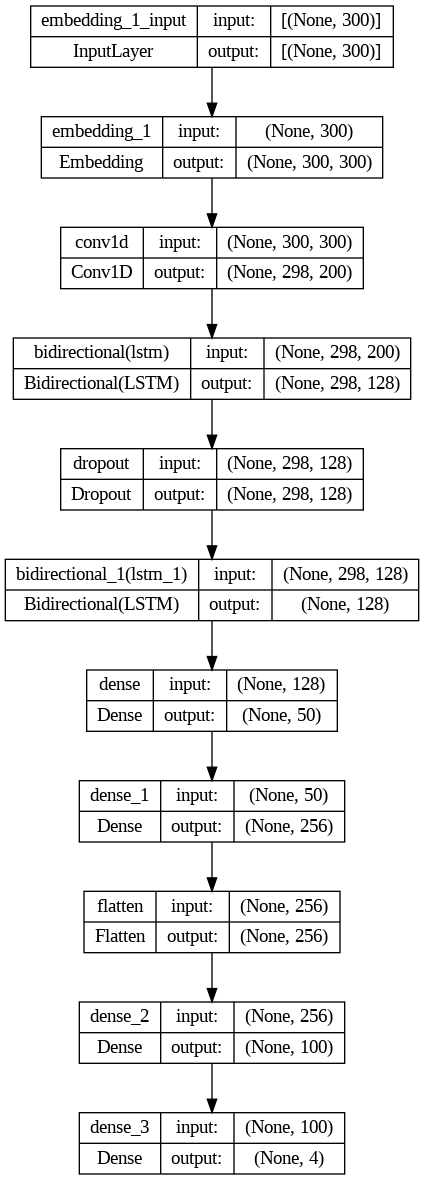

In [ ]:
#plot the vulgar detection model architecture
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='toxic_detection_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='toxic_detection_model_plot.png')

In [ ]:
history=model.fit(x_train,y_train,epochs=5,batch_size=256,validation_data=(x_test,y_test),use_multiprocessing=True, workers=8)

Epoch 1/5
64/64 [==============================] - 56s 457ms/step - loss: 0.4421 - accuracy: 0.5495 - val_loss: 0.3453 - val_accuracy: 0.7022
Epoch 2/5
64/64 [==============================] - 18s 277ms/step - loss: 0.2460 - accuracy: 0.7339 - val_loss: 0.2717 - val_accuracy: 0.7708
Epoch 3/5
64/64 [==============================] - 17s 258ms/step - loss: 0.1482 - accuracy: 0.8591 - val_loss: 0.2803 - val_accuracy: 0.8060
Epoch 4/5
64/64 [==============================] - 16s 259ms/step - loss: 0.0942 - accuracy: 0.8915 - val_loss: 0.3231 - val_accuracy: 0.7543
Epoch 5/5
64/64 [==============================] - 16s 243ms/step - loss: 0.0625 - accuracy: 0.8988 - val_loss: 0.4237 - val_accuracy: 0.8053


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


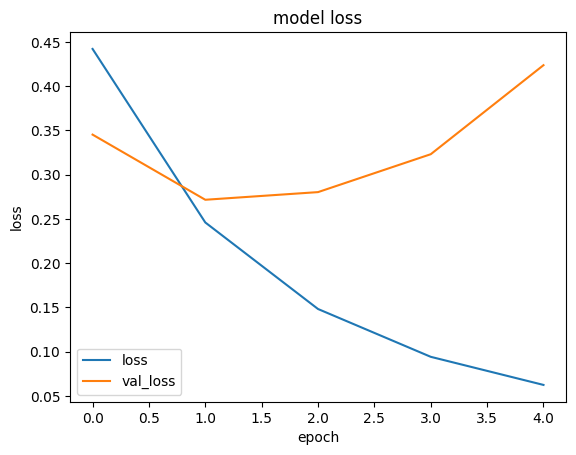

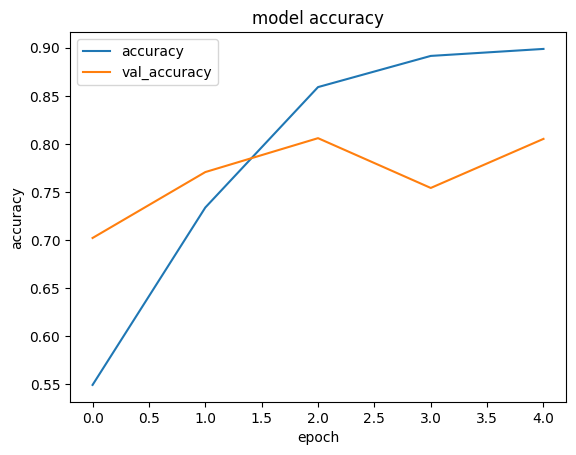

In [ ]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
#accuracy calculation
loss_and_metrics = model.evaluate(x_train,y_train,batch_size=24)
print("The train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model.evaluate(x_test,y_test,batch_size=24)
print("The test accuracy is: "+str(loss_and_metrics[1]))

677/677 [==============================] - 12s 18ms/step - loss: 0.0486 - accuracy: 0.9509
The train accuracy is: 0.9508843421936035
170/170 [==============================] - 3s 17ms/step - loss: 0.4237 - accuracy: 0.8053
The test accuracy is: 0.8052748441696167


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming you have the true labels for the test set stored in 'test_labels' and the model predictions stored in 'predictions'

# Get predicted probabilities from the model
predictions = model.predict(x_test)

# Convert predicted probabilities to binary labels
predicted_labels = np.zeros_like(predictions)
predicted_labels[np.arange(len(predictions)), predictions.argmax(1)] = 1

# Define the class labels
class_labels = ['toxic', 'threat', 'obscene', 'religious']

# Generate classification report
report = classification_report(y_test, predicted_labels, target_names=class_labels)

# Print the report
print(report)

127/127 [==============================] - 3s 17ms/step
              precision    recall  f1-score   support

       toxic       0.87      0.76      0.81      1960
      threat       0.75      0.57      0.65       414
     obscene       0.84      0.23      0.36      1783
   religious       0.93      0.81      0.87      1781

   micro avg       0.88      0.60      0.72      5938
   macro avg       0.85      0.59      0.67      5938
weighted avg       0.87      0.60      0.68      5938
 samples avg       0.88      0.67      0.74      5938

